# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 1000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)



11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.W = tf.Variable(tf.random.normal([in_features, out_features]), name="weights")
        self.b = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        return tf.sigmoid(tf.matmul(x, self.W) + self.b)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="dense_layer_1")

    # Второй слой, состоящий из 256 нейронов
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="dense_layer_2")

    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

  def __call__(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x)
    return tf.nn.softmax(x)

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
  trainable_variables = neural_net.trainable_variables
  gradients = g.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, accuracy(pred, output_y)

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    loss, acc = train(neural_net, batch_x, batch_y)
    
    loss_history.append(loss)
    accuracy_history.append(acc)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        acc = accuracy(pred, batch_y)
        print(f"Step {step}, Minibatch Loss: {loss}, Accuracy: {acc}")

Step 100, Minibatch Loss: 568.5004272460938, Accuracy: 0.12890625
Step 200, Minibatch Loss: 533.3743896484375, Accuracy: 0.1953125
Step 300, Minibatch Loss: 508.18609619140625, Accuracy: 0.3203125
Step 400, Minibatch Loss: 484.9932556152344, Accuracy: 0.47265625
Step 500, Minibatch Loss: 478.3973693847656, Accuracy: 0.4921875
Step 600, Minibatch Loss: 464.24237060546875, Accuracy: 0.57421875
Step 700, Minibatch Loss: 470.0133972167969, Accuracy: 0.58984375
Step 800, Minibatch Loss: 457.34002685546875, Accuracy: 0.60546875
Step 900, Minibatch Loss: 446.419189453125, Accuracy: 0.65625
Step 1000, Minibatch Loss: 440.3067626953125, Accuracy: 0.69921875


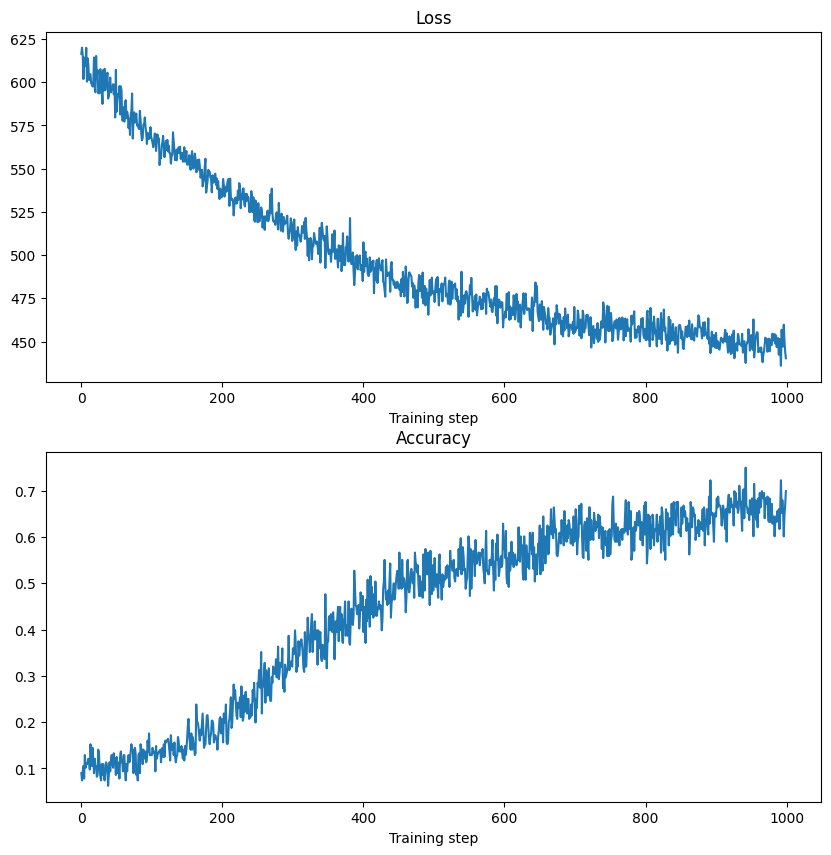

In [8]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].plot(loss_history)
axs[0].set_title("Loss")
axs[0].set_xlabel("Training step")
axs[1].plot(accuracy_history)
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Training step")
plt.show()

In [9]:
# Вычислите точность обученной нейросети

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)

accuracy_scores = []
for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    accuracy_scores.append(accuracy(pred, batch_y))

print("Accuracy:", np.mean(accuracy_scores))

Accuracy: 0.6828125


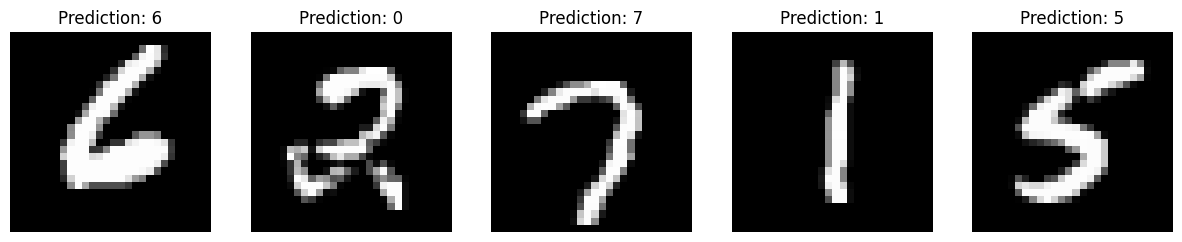

In [16]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

import random

indices = random.sample(range(len(x_test)), 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 15))

for i, idx in enumerate(indices):
    img = np.reshape(x_test[idx], (28, 28))
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

    pred = neural_net(np.reshape(x_test[idx], (1, -1)))
    class_idx = np.argmax(pred)

    axs[i].set_title("Prediction: {}".format(class_idx))

Нейронна мережа помимяеться, але майже в 70 відсотках робить правильну класифікацію, цей результат можна було б покращити якби збільшити training_steps, але нажаль не вистачае оперативної памяті.